In [1]:
# external imports
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from imblearn.under_sampling import NearMiss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# internal imports
import sys
sys.path.insert(0,'../')
from data_utils import add_deltas_and_time, scale_data, column_combinations, add_extreme

# Polynomial Regression Testing

In [2]:
data_850 = pd.read_csv('../NA850data_2000-2014.csv')
data_w_extreme = add_extreme(data_850)

In [3]:
# get scaled provided data with deltas and time added
X = data_850.drop(columns=['LH'])
X = add_deltas_and_time(X)
X = scale_data(X)

y = data_850['LH']
y_extreme = data_w_extreme['Extreme']

X.head()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,Lat,Lon,PtIndex,WaveTrajectory,dAirTemp,dQV,dOmega,dSeaLevPress,dUWinds,dVWinds,dLat,dLon,dPtIndex,dWaveTrajectory
Time,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,-5.894685,-0.921917,0.663327,2.255124,-0.838782,-1.512121,1.284264,0.046455,-0.904762,-1.252252,0.023965,-0.020884,0.001439,-0.031599,0.008588,-0.019885,-0.051313,1.086233,-1.0,0.0
2000-01-03 06:00:00,-3.680371,-0.425460,-0.022623,0.672601,-1.048340,-0.713308,0.730487,-0.914611,-0.047619,-1.252252,6.670923,2.258245,-0.935016,-2.753314,-0.637262,1.909090,-9.334594,-31.353357,17.0,0.0
2000-01-01 03:00:00,-5.871791,-0.875048,0.071067,2.125345,-0.711381,-0.966044,1.214122,-0.022959,-0.857143,-1.252252,-6.554269,-2.084847,0.129345,2.466917,1.047082,-0.630193,8.056147,31.182853,-18.0,0.0
2000-01-03 09:00:00,-3.512013,-0.464887,0.337309,0.527725,-0.801232,-0.684463,0.612075,-0.959157,0.000000,-1.252252,7.107577,1.862080,0.364911,-2.779281,-0.268328,0.660079,-10.143794,-30.513986,17.0,0.0
2000-01-01 06:00:00,-5.890387,-0.906401,0.462108,1.914790,-0.522681,-0.659917,1.234360,-0.077947,-0.809524,-1.252252,-7.115468,-2.047782,0.171814,2.353958,0.867068,0.039388,10.380425,30.830375,-18.0,0.0


In [4]:
len(y_extreme[y_extreme == 1]), len(y_extreme)

(2106, 20304)

In [5]:
undersampler = NearMiss(sampling_strategy=1)
X_under, y_extreme_under = undersampler.fit_resample(X, y_extreme)
y_under = y[undersampler.sample_indices_]

In [6]:
len(y_extreme_under[y_extreme_under == 1]), len(y_extreme_under)

(2106, 4212)

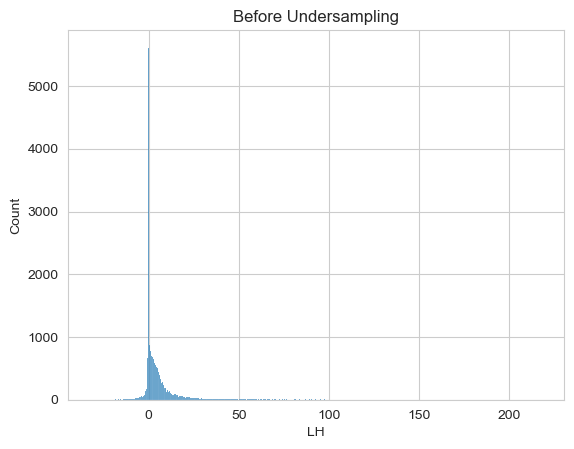

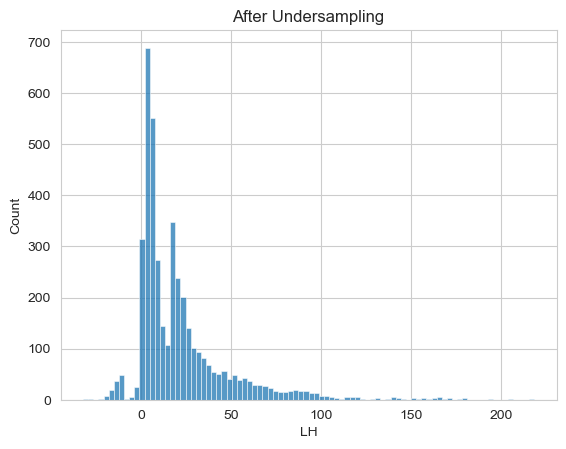

In [7]:
sns.histplot(y)
plt.title("Before Undersampling")
plt.show()
sns.histplot(y_under)
plt.title("After Undersampling")
plt.show()

In [8]:
LQ = data_850.LH.quantile(0.25)
UQ = data_850.LH.quantile(0.75)
bound = 1.5 * (UQ - LQ)  # Whisker length * IQR
lower_bound = LQ - bound
upper_bound = UQ + bound

def classify_extremes(y_pred):
    return np.where((y_pred > upper_bound) | (y_pred < lower_bound), 1, 0)

In [9]:
preselected_features = ["AirTemp", "QV", "Omega", "VWinds"]
features_to_select = [feature for feature in X.columns if feature not in preselected_features]

features_to_select

['SeaLevPress',
 'UWinds',
 'Lat',
 'Lon',
 'PtIndex',
 'WaveTrajectory',
 'dAirTemp',
 'dQV',
 'dOmega',
 'dSeaLevPress',
 'dUWinds',
 'dVWinds',
 'dLat',
 'dLon',
 'dPtIndex',
 'dWaveTrajectory']

In [10]:
poly_reg = Ridge(random_state=1)  # Ridge -> L2 regularization
X_train, X_test, y_train, y_test, y_ex_train, y_ex_test = \
    train_test_split(X_under, y_under, y_extreme_under, test_size=0.2, random_state=2)

# initialize metric list
log_csv = []

# test over degrees 1-4
degrees = [1, 2, 3]
for degree in degrees:
    # test over all combinations of a maximum length
    for comb in tqdm(column_combinations(features_to_select, max_len=5), desc=f"Degree {degree}"):
        # polynomial transform train and test inputs
        features_selected = preselected_features + comb
        poly = PolynomialFeatures(degree)
        X_train_poly = poly.fit_transform(X_train[features_selected])
        X_test_poly = poly.fit_transform(X_test[features_selected])

        # fit and predict train and test
        poly_reg.fit(X_train_poly, y_train)
        y_pred_train = poly_reg.predict(X_train_poly)
        y_pred_test = poly_reg.predict(X_test_poly)

        y_pred_ex_train = classify_extremes(y_pred_train)
        y_pred_ex_test = classify_extremes(y_pred_test)

        # log training and testing metrics to list
        log_csv.append(
            [degree, features_selected,
            mean_squared_error(y_train, y_pred_train),  # train MSE
            mean_squared_error(y_test, y_pred_test),  # test MSE
            r2_score(y_train, y_pred_train),  # train r^2
            r2_score(y_test, y_pred_test),  # test r^2
            accuracy_score(y_ex_train, y_pred_ex_train),  # train accuracy
            accuracy_score(y_ex_test, y_pred_ex_test),  # test accuracy
            f1_score(y_ex_train, y_pred_ex_train),  # train f1
            f1_score(y_ex_test, y_pred_ex_test)]  # test f1
        )

Degree 1:   0%|          | 0/6884 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
log_csv_sorted = sorted(log_csv, key=lambda l: l[-1], reverse=True)  # sort by max testing f1
# convert to dataframe and write to file
log_df = pd.DataFrame(log_csv_sorted, columns=["degree", "feature_combination", "train_MSE",
                                               "test_MSE", "train_r^2", "test_r^2", "train_acc",
                                               "test_acc", "train_F1", "test_F1"])
log_df.to_csv("polyreg_results.csv", sep="|", index=False)